# **Detection of Malaria cells using Convolution Neural Network**

In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

In [5]:
my_data_dir = '../input/files1/Malaria Cells'

In [6]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(my_data_dir) 

['testing_set', 'single_prediction', 'training_set']

In [7]:
test_path = my_data_dir+'/testing_set'
train_path = my_data_dir+'/training_set'

In [8]:
os.listdir(test_path)

['Uninfected', 'Parasitized']

In [9]:
os.listdir(train_path)

['Uninfected', 'Parasitized']

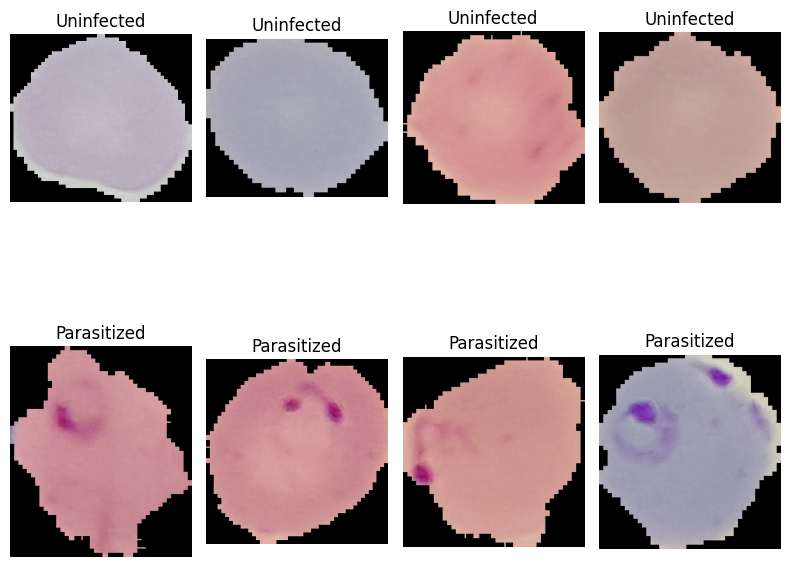

In [10]:
# Define the directories to iterate over
directories = ['Uninfected', 'Parasitized']
# Plot the first four images from both directories
plt.figure(figsize=(8, 8))

for i, directory in enumerate(directories):
    # Path to the current directory
    dir_path = os.path.join(train_path, directory)
    
    # List of image files in the directory
    files = os.listdir(dir_path)[:4]  # Select first four images
    
    # Plot the images
    for j, filename in enumerate(files):
        image_path = os.path.join(dir_path, filename)
        image = imread(image_path)
        
        # Calculate the position of the subplot
        position = i*4 + j + 1
        
        # Plot the image
        plt.subplot(2, 4, position)
        plt.imshow(image)
        plt.title(directory)
        plt.axis('off')
plt.tight_layout()
plt.show()

**Let's check how many images there are.**

In [11]:
len(os.listdir(train_path+'/Parasitized'))

13780

In [12]:
len(os.listdir(train_path+'/Uninfected'))

13780

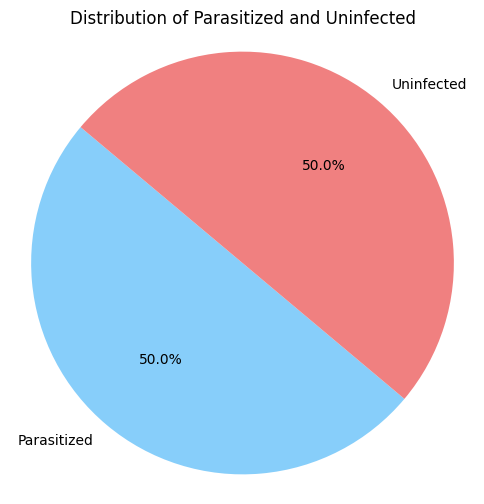

In [13]:
# Get the number of images in each class
num_parasitized = len(os.listdir(train_path+'/Parasitized'))
num_uninfected = len(os.listdir(train_path+'/Uninfected'))

# Create a pie chart
plt.figure(figsize=(6, 6))
labels = ['Parasitized', 'Uninfected']
sizes = [num_parasitized, num_uninfected]
colors = ['lightskyblue', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Parasitized and Uninfected')
plt.show()

**Let's find out the average dimensions of these images.**

In [14]:
unifected_cell_path = train_path+'/Parasitized/'+os.listdir(train_path+'//Parasitized')[0]
unifected_cell = imread(unifected_cell_path)
unifected_cell.shape

(151, 130, 3)

In [15]:
Parasitized_cell_path = train_path+'/Parasitized/'+os.listdir(train_path+'//Parasitized')[2]
Parasitized_cell = imread(Parasitized_cell_path)
Parasitized_cell.shape

(130, 124, 3)

In [16]:
image_shape = (130,130,3)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 10%
                               height_shift_range=0.10, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [19]:
image_gen.flow_from_directory(train_path)

Found 27558 images belonging to 2 classes.


In [20]:
image_gen.flow_from_directory(test_path)

Found 15832 images belonging to 2 classes.


# Creating the Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
import warnings
warnings.filterwarnings("ignore")

In [22]:
# Initialising the CNN
classifier = Sequential()

#1 - Convolution
classifier.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

#2 - Pooling
# Hidden Layer 1
classifier.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a second convolution layer
# relu turns negative values in images to 0
classifier.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

#3 - Flattening
# converts the matrix in a singe array
classifier.add(Flatten())


classifier.add(Dense(128))
classifier.add(Activation('relu'))


# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
classifier.add(Dropout(0.5))

#4 - Full Connection
# 128 is the final layer of outputs & from that 1 will be considered.
# Last layer, remember its binary so we use sigmoid
classifier.add(Dense(1))
classifier.add(Activation('sigmoid'))

classifier.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 62, 62, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 29, 29, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## Early Stopping

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

## Training the Model

In [26]:
batch_size = 32

In [27]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 27558 images belonging to 2 classes.


In [28]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 15832 images belonging to 2 classes.


In [29]:
train_image_gen.class_indices

{'Parasitized': 0, 'Uninfected': 1}

In [31]:
history = classifier.fit(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 302s 342ms/step - accuracy: 0.6743 - loss: 0.5744 - val_accuracy: 0.9372 - val_loss: 0.1784
Epoch 2/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 204s 235ms/step - accuracy: 0.9414 - loss: 0.1815 - val_accuracy: 0.9430 - val_loss: 0.1788
Epoch 3/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 205s 236ms/step - accuracy: 0.9478 - loss: 0.1662 - val_accuracy: 0.9444 - val_loss: 0.1622
Epoch 4/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 205s 236ms/step - accuracy: 0.9489 - loss: 0.1624 - val_accuracy: 0.9478 - val_loss: 0.1513
Epoch 5/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 205s 237ms/step - accuracy: 0.9525 - loss: 0.1556 - val_accuracy: 0.9488 - val_loss: 0.1446
Epoch 6/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 205s 237ms/step - accuracy: 0.9502 - loss: 0.1533 - val_accuracy: 0.9450 - val_loss: 0.1670
Epoch 7/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 207s 239ms/step - accuracy: 0.9541 - loss: 0.1471 - val_accuracy: 0.9486 - val_loss: 0.1438
Epoch 8/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 206s 238ms/step - accuracy: 0.9526 -

> I used 0.5 or 50% dropping of neurons while training to avoid overfitting problem (dropout)

495/495 ━━━━━━━━━━━━━━━━━━━━ 76s 153ms/step - accuracy: 0.9375 - loss: 0.1674
Test Loss: 0.1359, Test Accuracy: 0.9519


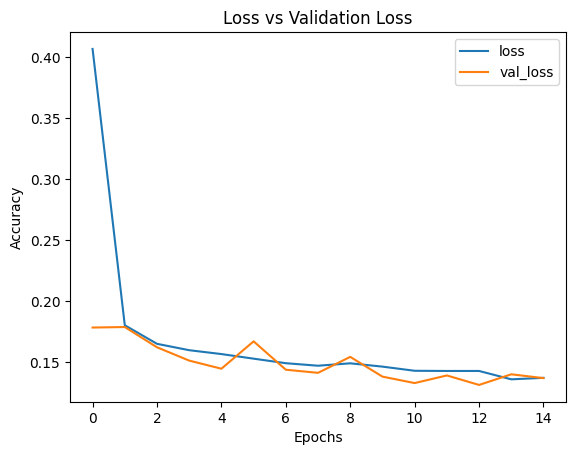

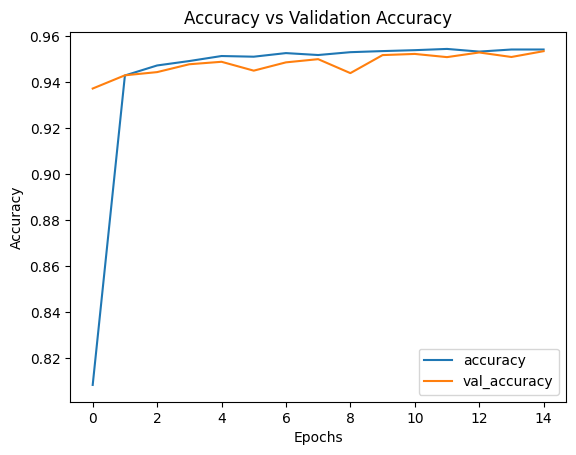

In [33]:
# Plot training and validation loss
losses = pd.DataFrame(history.history)
losses[['loss', 'val_loss']].plot(title='Loss vs Validation Loss', ylabel='Accuracy', xlabel='Epochs')

# Plot training and validation accuracy
losses[['accuracy', 'val_accuracy']].plot(title='Accuracy vs Validation Accuracy', ylabel='Accuracy', xlabel='Epochs')


# Evaluate the model
results = classifier.evaluate(test_image_gen)
test_loss = results[0]
test_accuracy = results[1]
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

In [40]:
classifier.metrics_names

['loss', 'compile_metrics']

In [42]:
classifier.evaluate(test_image_gen)

495/495 ━━━━━━━━━━━━━━━━━━━━ 75s 152ms/step - accuracy: 0.9377 - loss: 0.1690


[0.13433903455734253, 0.9525012373924255]

In [43]:
from tensorflow.keras.preprocessing import image

In [44]:
pred_probabilities = classifier.predict(test_image_gen)

495/495 ━━━━━━━━━━━━━━━━━━━━ 74s 149ms/step


In [45]:
pred_probabilities

array([[9.8646757e-05],
       [5.6247632e-03],
       [4.8431426e-05],
       ...,
       [9.7522980e-01],
       [9.9408132e-01],
       [9.5174497e-01]], dtype=float32)

In [46]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [47]:
predictions = pred_probabilities > 0.5

In [48]:
# Numpy can treat this as True/False for us
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [49]:
from sklearn.metrics import classification_report,confusion_matrix

In [50]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      7952
           1       0.94      0.97      0.95      7880

    accuracy                           0.95     15832
   macro avg       0.95      0.95      0.95     15832
weighted avg       0.95      0.95      0.95     15832



In [51]:
confusion_matrix(test_image_gen.classes,predictions)

array([[7428,  524],
       [ 261, 7619]])

Confusion Matrix:


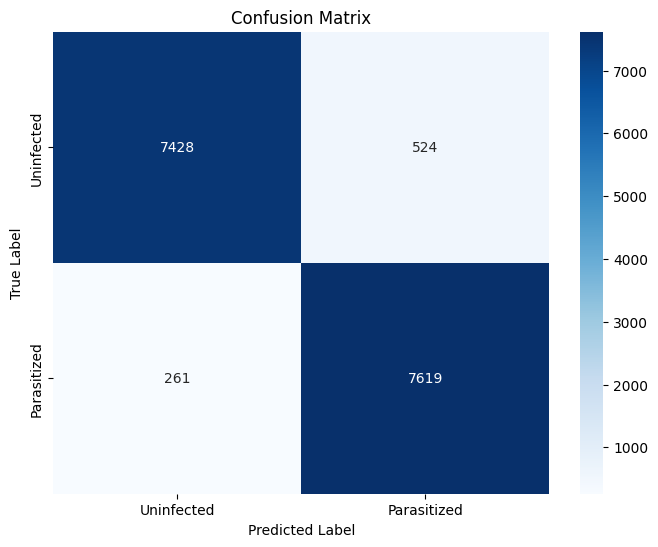

In [52]:
# Confusion Matrix
cm = confusion_matrix(test_image_gen.classes, predictions)
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()